# Projeto 3 -  Clusterização

## Informações do Projeto
DataSet:<br /><br />https://www.kaggle.com/new-york-city/nyc-property-sales
     nyc-property-sales

Grupo:
      Antonio Andraues<br />
      Lucca Delchiaro <br/ >
      Joao Edvirges.<br /><br />


In [5]:
import math
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import numpy as np

In [6]:
dados=pd.read_csv("nyc-rolling-sales.csv")
dados


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00
5,9,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,,C4,516 EAST 12TH STREET,...,20,0,20,2581,9730,1900,2,C4,-,2017-07-20 00:00:00
6,10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,...,8,0,8,1750,4226,1920,2,C4,3192840,2016-09-23 00:00:00
7,11,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,,C7,520 EAST 14TH STREET,...,44,2,46,5163,21007,1900,2,C7,-,2017-07-20 00:00:00
8,12,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,,D5,141 AVENUE D,...,15,0,15,1534,9198,1920,2,D5,-,2017-06-20 00:00:00
9,13,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,...,24,0,24,4489,18523,1920,2,D9,16232000,2016-11-07 00:00:00


    A partir do dataset escolhido, a equipe percebeu que há questões de sensibilidades em relação aos algoritmos disponíveis. Partindo do princípio de que o dataset está possui informações de boa qualidade, achou-se melhor optar dentre DBSCAN, K-Means e Mean Shift, o algoritmo Mean Shift por ter mais afinidade as nossas váriaveis.(doc:http://scikit-learn.org/stable/modules/clustering.html). Numa rápida lida no data base, viu-se a necessidade de definir quais regiões possuem high budget e low budget. Para isso, um elemento necessário e identificar para qual centróide cada ponto está convergindo, dando uma idéia de agrupamento e assim definindo cada bairro com sua income.Porém para esse cluster ficar apresentável, sabe-se que um processo de smoothing será necessário, pois mesmo dentro de divisões via renda, ainda assim dentro de uma classe, possui-se diferenças grandes nas rendas e nas depesas.Por isso a escolha do mean shift, que vai pegar cada ponto convergindo e dar uma suavizada nesse resultados, mostrando mais definido cada região.(Doc:https://www.youtube.com/watch?v=yTsslXB5v1s,https://www.youtube.com/watch?v=yhz8Fm0ymm8)
   O mean shift e utilizado em suavização de pixels, diminuindo as diferenças que cada cor possui, tornando a imagem de saída menos discrepante. 
   
   Segue o exemplo de um cluster via Mean Shift:
  http://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html
  
  A biblioteca que a equipe vai importar e a própria do scikit learn.

In [202]:
dados2=dados.loc[:,['NEIGHBORHOOD','SALE PRICE','BLOCK']] #selecionando os subsets que vamos trabalhar
dados2=dados2.rename(columns={'SALE PRICE': 'SALE_PRICE'}) #facilitar a representacao da coluna
dados2.SALE_PRICE[2] #Formato do preco nao completado
dados2=dados2.loc[dados2.SALE_PRICE!=' -  ']  #retirada do formato "Nao completado"
dados2=dados2.loc[dados2.SALE_PRICE.astype('int')]###AQUI!!!####
dados2.head()

OverflowError: Python int too large to convert to C long

In [180]:
n=4  #numeros de bairros
bairros = dados2.NEIGHBORHOOD[~dados2.NEIGHBORHOOD.duplicated(keep='first')] #Nomes de todos os bairros uma unica vez
primeirosB=bairros[:n] #primeiros 10 bairros para analize
primeirosBairros=[] #colocando os nomes em uma lista
for i in primeirosB:
    primeirosBairros.append(i)
    
pp=[]    
Precos=[]         #pegando os precos para cada bairro
for u in primeirosBairros:  
    ppp=dados2.loc[dados2.NEIGHBORHOOD==u]
    pp.append(ppp)  #Serve para analizar cada bairro individualmente
    for c in range(0,len(ppp)):
        preco=ppp.SALE_PRICE
    Precos.append(preco)

#dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste    

# Plot
# fig, ax = plt.subplots()
# ax.legend()

# plt.show()

# dd=pd.DataFrame(np.random.rand(len(preco), n),columns=[primeirosBairros]) #Gerado randomicamente so para teste
# print(dd.max())

# ax = dd.plot.scatter(x=primeirosBairros[0], y=primeirosBairros[0], color='DarkBlue', label=primeirosBairros[0]);
# dd.plot.scatter(x=primeirosBairros[1], y=primeirosBairros[1], color='DarkGreen', label=primeirosBairros[1], ax=ax);

# plt.show()



In [194]:
# N = 5 #ESQUECER ESSA PARTE (SO TESTES)
# arr = np.arange(N*2).reshape(N,2)
# words=np.array(primeirosBairros)
# df = pd.DataFrame(words[arr % 10], columns=list('XY'))
# df['Z'] = dados2.SALE_PRICE
# Xuniques, X = np.unique(df['X'], return_inverse=True)
# Yuniques, Y = np.unique(df['Y'], return_inverse=True)

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.scatter(X, Y, Z, s=20, c='b')
# ax.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
#        yticks=range(len(Yuniques)), yticklabels=Yuniques) 
# plt.show()

In [200]:
pp

[]

In [199]:


headers = pp.pop(0)



In [189]:
headers.describe()

,BLOCK
count,659.000000
mean,753.323217
std,37.121507
min,690.000000
25%,720.000000
50%,765.000000
75%,792.000000
max,803.000000


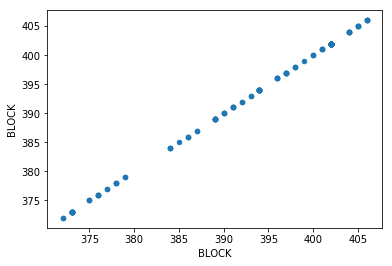

In [185]:
#OLHA ISSO




headers.plot.scatter(x="BLOCK",y="BLOCK")

KeyError: 'SALE_PRICE'

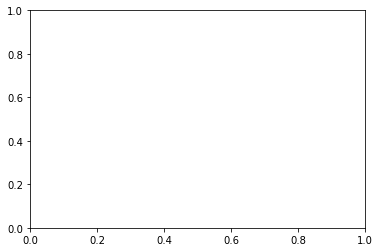

In [186]:
#E ISSO

#Ta dando problema com o sale price......

headers.plot.scatter(x="BLOCK",y="SALE_PRICE")

In [187]:
headers['SALE_PRICE']

0       6625000
3       3936272
4       8000000
6       3192840
9      16232000
11     10350000
12            1
13       499000
14           10
15       529500
16       423000
17       501000
18       450000
19       510000
21       350000
22     11900000
23     11900000
24       350000
25       404000
26       535000
27      1400000
28       866000
29       355000
31       805000
32       475000
33       450000
34       450000
35       810000
37       300000
38       300000
         ...   
164     1578287
165     1400093
166     4552375
168      750000
169     2385000
170     1400093
171     1478499
172     3300000
173     7215000
174     4750000
176      805000
177      735000
178      810000
180     3035000
181      630000
182      680000
184      995000
185      494500
186     1875000
187     2700000
188     1500000
189      635000
190      700000
191     1100000
192     1900000
193      485000
194     1175000
195     3700000
199    10800000
200    52625000
Name: SALE_PRICE, Length

In [160]:
Precos.count()


TypeError: count() takes exactly one argument (0 given)

In [77]:
P=pd.DataFrame(pp).transpose()
P#.plot.scatter()


,0,1,2,3
0,NEIGHBORHOOD SALE_PRICE BLOCK 0 ALPH...,NEIGHBORHOOD SALE_PRICE BLOCK 206 CH...,NEIGHBORHOOD SALE_PRICE BLOCK 1008 CH...,NEIGHBORHOOD SALE_PRICE BLOCK 1122 CIV...


In [56]:
P

,SALE_PRICE
0,6625000
3,3936272
4,8000000
6,3192840
9,16232000
11,10350000
12,1
13,499000
14,10
15,529500
